**Pancreatic Cancer Risk Factor Prediction Model**

This notebook explores an initial machine learning model for the prediction of pancreatic cancer from known risk factors. The model is a proof of concept for a larger machine learning model which would be based off more risk factors to predict pancreatic cancer more accurately in at risk patient groups. 

This code forms part of a third-year undergraduate project as part of the MEng in Engineering Science at the University of Oxford.



**Data Provenance and Prior Work**

The data used to train these exploratory models is from [Debernardia et al's 2020 paper ](http://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489). This paper extends the PanRisk risk factor model first set out by [Radon et al](https://aacrjournals.org/clincancerres/article/21/15/3512/78917/Identification-of-a-Three-Biomarker-Panel-in-Urine). This is a pancreatic risk factor model based off of statistical analysis of urinary biomarkers. Debernardia et al extend this to include the CA19-9 biomarker and perform statistical analysis on the PanRisk score using this new factor, as well as evaluating REG1B compared to REG1A.

The data obtained is from: Barts Pancreas Tissue Bank, University College London, University of Liverpool, Spanish National Cancer Research Center,
Cambridge University Hospital, and University of Belgrade and contains 590 specimens, 199 of which are Pancreatic cancer patients. The format of this data has been slightly changes, as is seen in the description, and uploaded to Kaggle as seen here https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer. There are a range of other successful models that have been implemented as part of this competition, and the workings of these are commended as background reading for this text, particularly Idriss Jairi's detailed data analysis seen here https://www.kaggle.com/code/idrissjairi/pancreatic-cancer-as-binary-classification-90/notebook.


**Sample selection**

This model forms part of the exploratory work for a larger model which would be trained on more risk factors. The aim of this model is to provide GPs with an aid to synthesise the array of nonspecific risk factors and symptoms that suggest pancreatic cancer. Our 3rd Year design project focuses on combing this model in primary care, with a CT scan model. A pathway where at risk patients will be flagged early for CT scans based on this model will be created. These patients will then have their scans assessed by medical imaging with the eventual aim of a streamlined early pancreatic cancer detection pathway.

To reduce overdiagnosis, we are postulating that these models only be applied to those at higher risk of pancreatic cancer. As such, data not from these groups is removed from the model as we want to only train our model over data types which will interact with in the wild.

Secondly, we aim to produce a binary classification model; we will output that a patient is at high risk of cancer, or that our model doesn't consider the patient at high risk. As such, the 3-stage system implemented in the data presentation is formatted to 0=no cancer, 1=cancer. Machine learning models are then applied to this data as a proof of concept that we are able to effectively predict pancreatic cancer risk based off risk factors.


**Data processig and cleaning**

In [1]:
#Import standard libraries for data science, and other things I need.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
#Import the data; this is from the kaggle competition it was uploaded to.
data = pd.read_csv("/kaggle/input/urinary-biomarkers-for-pancreatic-cancer/Debernardi et al 2020 data.csv")
data_descritpion = pd.read_csv("/kaggle/input/urinary-biomarkers-for-pancreatic-cancer/Debernardi et al 2020 documentation.csv")

In [3]:
##Display the data discrption for understanding
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
##Data set information: Age analysis

#Find how many samples we have
total_people = len(data)
print(f"Total number of people: {total_people}")

# Print the number of people with pancreatic cancer (PDAC)
pdac_count = len(data[data['diagnosis'] == 3])
print(f"Number of people with pancreatic cancer (PDAC): {pdac_count}")

#Get the average age of those with pdac and the number of men and women
avg_age_pdac = data[data['diagnosis'] == 3].groupby('sex')['age'].mean()
number_pdac = data[data['diagnosis'] == 3].groupby('sex').size()
print("\nAverage Age for Men and Women with PDAC:")
print(avg_age_pdac)
print(number_pdac)


# Do the same for those without pdac
avg_age_no_pdac = data[data['diagnosis'] != 3].groupby('sex')['age'].mean()
print("\nAverage Age for Men and Women without PDAC:")
print(avg_age_no_pdac)
number_no_pdac=data[data['diagnosis']!=3].groupby('sex').size()
print(number_no_pdac)




Total number of people: 590
Number of people with pancreatic cancer (PDAC): 199

Average Age for Men and Women with PDAC:
sex
F    67.228916
M    65.431034
Name: age, dtype: float64
sex
F     83
M    116
dtype: int64

Average Age for Men and Women without PDAC:
sex
F    55.518519
M    55.400000
Name: age, dtype: float64
sex
F    216
M    175
dtype: int64


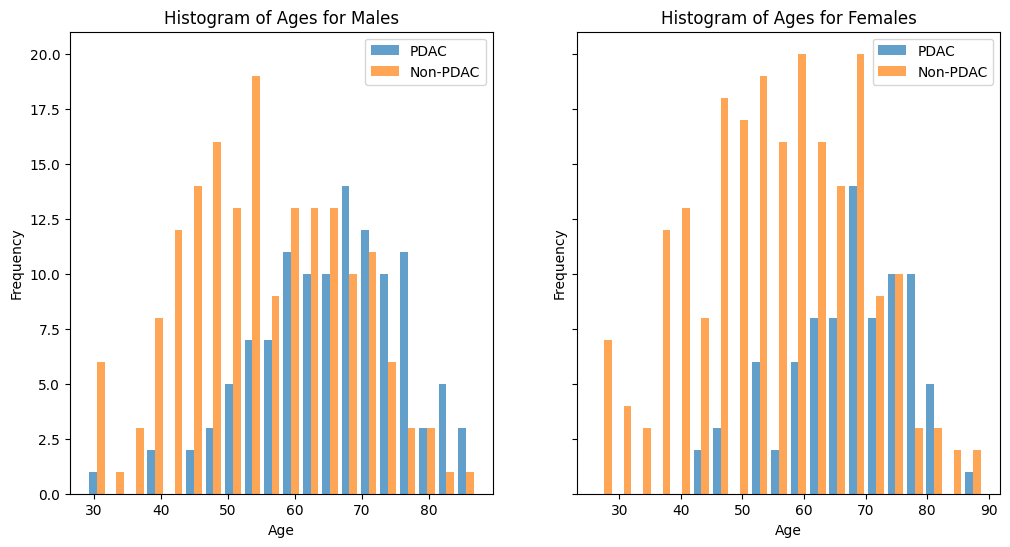

In [5]:
male_data = data[data['sex'] == 'M']
female_data = data[data['sex'] == 'F']

# Create two subplots for males and females
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot histogram for males
ax1.hist([male_data[male_data['diagnosis'] == 3]['age'], male_data[male_data['diagnosis'] != 3]['age']],
         bins=20, alpha=0.7, label=['PDAC', 'Non-PDAC'])
ax1.set_title('Histogram of Ages for Males')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot histogram for females
ax2.hist([female_data[female_data['diagnosis'] == 3]['age'], female_data[female_data['diagnosis'] != 3]['age']],
         bins=20, alpha=0.7, label=['PDAC', 'Non-PDAC'])
ax2.set_title('Histogram of Ages for Females')
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.legend()

# Save the figure
plt.savefig('/kaggle/working/ages_orginal.png')

# Show the plot
plt.show()

In [6]:
# Data set analysis: location and CA19-9 reading
pdac_samples_ca19_9 = data[data['diagnosis'] == 3].groupby('plasma_CA19_9').size()
print("\nSamples with PDAC by CA19-9 Reading:")
print(pdac_samples_ca19_9)

# Do the same for those without PDAC
no_pdac_samples_ca19_9 = data[data['diagnosis'] != 3].groupby('plasma_CA19_9').size()
print("\nSamples without PDAC by CA19-9 Reading:")
print(no_pdac_samples_ca19_9)



Samples with PDAC by CA19-9 Reading:
plasma_CA19_9
0.60        1
1.00        1
3.04        1
6.00        1
6.90        1
           ..
9436.00     1
11740.00    1
13740.00    1
18360.00    1
31000.00    1
Length: 145, dtype: int64

Samples without PDAC by CA19-9 Reading:
plasma_CA19_9
0.000000       1
0.051565       1
0.056476       1
0.139962       1
0.457134       1
              ..
190.700000     1
263.000000     1
323.000000     1
1541.000000    1
1913.000000    1
Length: 138, dtype: int64


**Data Selection**

The aims of the paper from which this data is sourced are different to our aims. As such, we will not use all data columns when predicting pancreatic cancer.

Firstly, as we aim to have a generalisable model across geographies, we will drop sample origin. Note the it has been found in some studies xxx yyy that predictive factors can vary across geographies so an advanced model may want to be trained separately in geographical localities where it is used.


In [7]:
## Drop sample origin and patient cohort
columns_to_drop = ['sample_origin', 'patient_cohort']
data = data.drop(columns=columns_to_drop)

#display some rows of the new dataset to show changes made.
data.head()

,sample_id,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


We would also like to make our problem binary, as is the goal of our classifier. We will therefore drop begnin_sample_diagnoisis, and stage. We will also group diagnosis into two groups, setting both 1 and 2 to 0 and 3 to 1, classsifying soley as cancer or no cancer.

In [8]:
# Drop the specified columns
columns_to_drop = ['benign_sample_diagnosis', 'stage']
data = data.drop(columns=columns_to_drop)

# Modify the "diagnosis" column
data['diagnosis'] = data['diagnosis'].replace({1: 0, 2: 0, 3: 1})

## Show some rows of the new dataframe
data.head()



,sample_id,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,33,F,0,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,81,F,0,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,51,M,0,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,61,M,0,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,62,M,0,9.0,0.21489,0.000860,65.54000,41.088000,NaN


**Data Analysis**

Now the data is cleaned, we need to check the composition of our data.

Firstly, we want to only consider data from our at risk group. For the data here, the only indicative variable we have to assess whether they would be in this category is their age. As such, we filter out all those 45 and younger. 

We are aiming to target the use of a large scale model to those at highest risk. The reasoning for this is that pancreatic cancer has a low prevalence and as our proposed pathway involves sending those patients at risk a CT scan, even a respectable specificity could possible overwhelm the NHS with needless CT scans. By targeting only the at risk group we aim to minimise missed cases but maximise specificity.


   Total People  Total with Cancer  % with Cancer  People Over 45  \
0           590                199      33.728814             494   

   Over 45 with Cancer  % Over 45 with Cancer  
0                  192              38.866397  


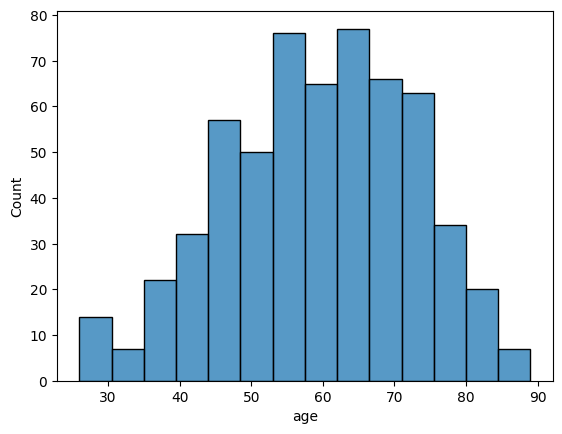

In [9]:
# Plot a histogram of the data prior to age sectioning
sns.histplot(data.age)


# Calculate EDA metrics
total_people = len(data)
total_with_cancer = data['diagnosis'].sum()
people_over_45 = len(data[data['age'] > 45])
people_over_45_with_cancer = len(data[(data['age'] > 45) & (data['diagnosis'] == 1)])
percentage_cancer = (total_with_cancer / total_people) * 100
percentage_people_over_45_with_cancer = (people_over_45_with_cancer / people_over_45) * 100

# Create a DataFrame for the table
table_data = {
    'Total People': [total_people],
    'Total with Cancer': [total_with_cancer],
    '% with Cancer': [percentage_cancer],
    'People Over 45': [people_over_45],
    'Over 45 with Cancer': [people_over_45_with_cancer],
    '% Over 45 with Cancer': [percentage_people_over_45_with_cancer]
}

result_table = pd.DataFrame(table_data)

# Display the result
print(result_table)

In [10]:
# Drop those younger than 45
data = data[data['age'] >= 45]

**CA19-9 Levels**

A key component of our proposed large scale model is CA19-9, in part due to ease of access of blood from newly diagnosed diabetics who are a at risk group we are paying particular focus to.
Some field are missing, so we shall explore the amount of CA19-9 data we have and what fields within the data set are missing.

In [11]:

# Count the number of samples with missing values for CA19-9
missing_ca199_count = data['plasma_CA19_9'].isna().sum()

# Calculate the percentage of samples with missing values for CA19-9
percentage_missing_ca199 = (missing_ca199_count / len(data)) * 100

# Display the results
print(f"Number of samples with missing CA19-9 values: {missing_ca199_count}")
print(f"Percentage of samples with missing CA19-9 values: {percentage_missing_ca199:.2f}%")


Number of samples with missing CA19-9 values: 204
Percentage of samples with missing CA19-9 values: 40.48%


As a large percantage of our population doesn't have CA199 reading, we will first train a  model on the population that do have the CA199 markers, we can then use this model to test how well our model will be able to perform when there are missing features; we'll do this by using the same model to test on the other data set.

In [12]:
##Create a new data set with the section that has CA19_9 data included.
data_blood = data.dropna(subset=['plasma_CA19_9']).copy()
data_blood.head()

,sample_id,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
2,S100,51,M,0,7.0,0.78039,0.145589,102.366,461.141,NaN
3,S101,61,M,0,8.0,0.70122,0.002805,60.579,142.950,NaN
4,S102,62,M,0,9.0,0.21489,0.000860,65.540,41.088,NaN
7,S105,58,F,0,11.0,0.89349,0.003574,3.730,40.294,NaN
9,S107,56,F,0,24.0,0.61074,0.278778,83.928,19.185,NaN


We've now created a seperate data set for only CA19_9 data, we shall train an intail model on this

**CA19_9 Data Set Cleaning**

We shall prepare the CA19_9 data set for ML and do some EDA.

In [13]:
## We need to check for other columns that have NA
data_blood.isna().sum()

sample_id          0
age                0
sex                0
diagnosis          0
plasma_CA19_9      0
creatinine         0
LYVE1              0
REG1B              0
TFF1               0
REG1A            118
dtype: int64

We can see the only column we have an issue with is REG1A, we need to analyse this and decide how to deal with it.

<Axes: xlabel='REG1A', ylabel='Count'>

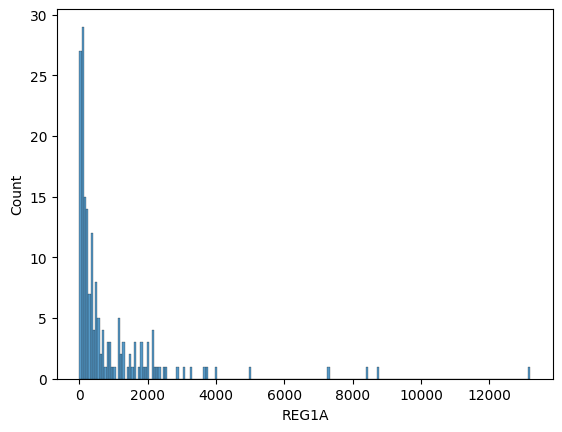

In [14]:
sns.histplot(data_blood.REG1A, bins = 200)

In [15]:
data_blood.REG1A.value_counts()

REG1A
0.000        6
137.000      2
245.385      1
206.892      1
3761.625     1
            ..
79.423       1
876.901      1
2488.000     1
57.678       1
13200.000    1
Name: count, Length: 176, dtype: int64

In [16]:
 #Find the median of the remaining values
np.nanmedian(data_blood.REG1A)


319.0185

Observing the distribution of data, and the median, I'm going to set the missing REG1A values to the median. This is a design decision for this experiment but in a real application would be akin to setting a missing value to a reference expected REG1A level. This is a design choice and should be evaluated in a full model, but for this experiment, we will proceed with the mean.

In [17]:
#Set all NaN to the medain of the non NaN, as described above.
data_blood['REG1A'] = data_blood['REG1A'].fillna(value=np.nanmedian(data_blood['REG1A']))


Let's exmain the new data_blood.

<Axes: xlabel='REG1A', ylabel='Count'>

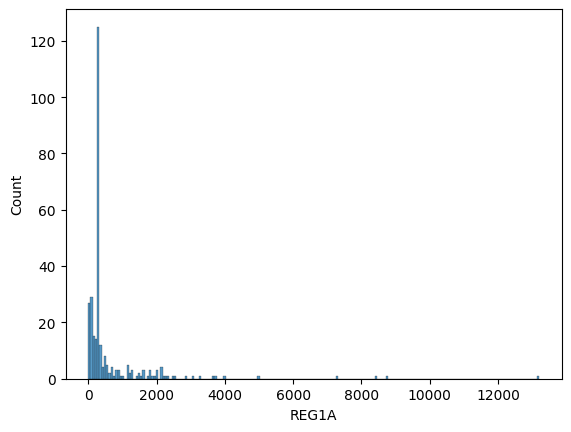

In [18]:
sns.histplot(data_blood.REG1A, bins = 200)

As we'd expect, we've added a huge spike at the median. This theoretically corresponds to most people being at the expected level, and in a clincial setting would be like ignoring a missing value, thus assuming it is normal.

We now have a data set we can analyse.

In [19]:
data_blood.isna().sum()

sample_id        0
age              0
sex              0
diagnosis        0
plasma_CA19_9    0
creatinine       0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
dtype: int64

In [20]:
data_blood.columns

Index(['sample_id', 'age', 'sex', 'diagnosis', 'plasma_CA19_9', 'creatinine',
       'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')

We have no use for sample id, and the only other categorical column is the pateint sex, which we can turn into a binary 1 male 0 female.


In [21]:
data_blood = data_blood.drop(columns=['sample_id'])

# Convert 'sex' column to binary (1 for male, 0 for female) and rename to 'm'
data_blood['m'] = data_blood['sex'].map({'M': 1, 'F': 0})

# Drop the original 'sex' column
data_blood = data_blood.drop(columns=['sex'])

In [22]:
data_blood.sample(5)

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,m
528,54,1,399.00,1.27803,6.985349,26.716746,769.998600,116.715,0
466,66,1,36.27,1.22148,10.022640,367.560200,982.068504,1310.506,1
440,68,1,91.00,2.30724,6.221869,63.468804,583.193500,78.535,1
554,60,1,2204.00,1.60602,2.236909,305.035680,2805.294618,8731.000,1
511,67,1,755.00,0.37323,9.672798,369.256580,2719.353300,1646.490,1


**Exploratory Data Analysis**


Now all the data is cleaned we will do some EDA

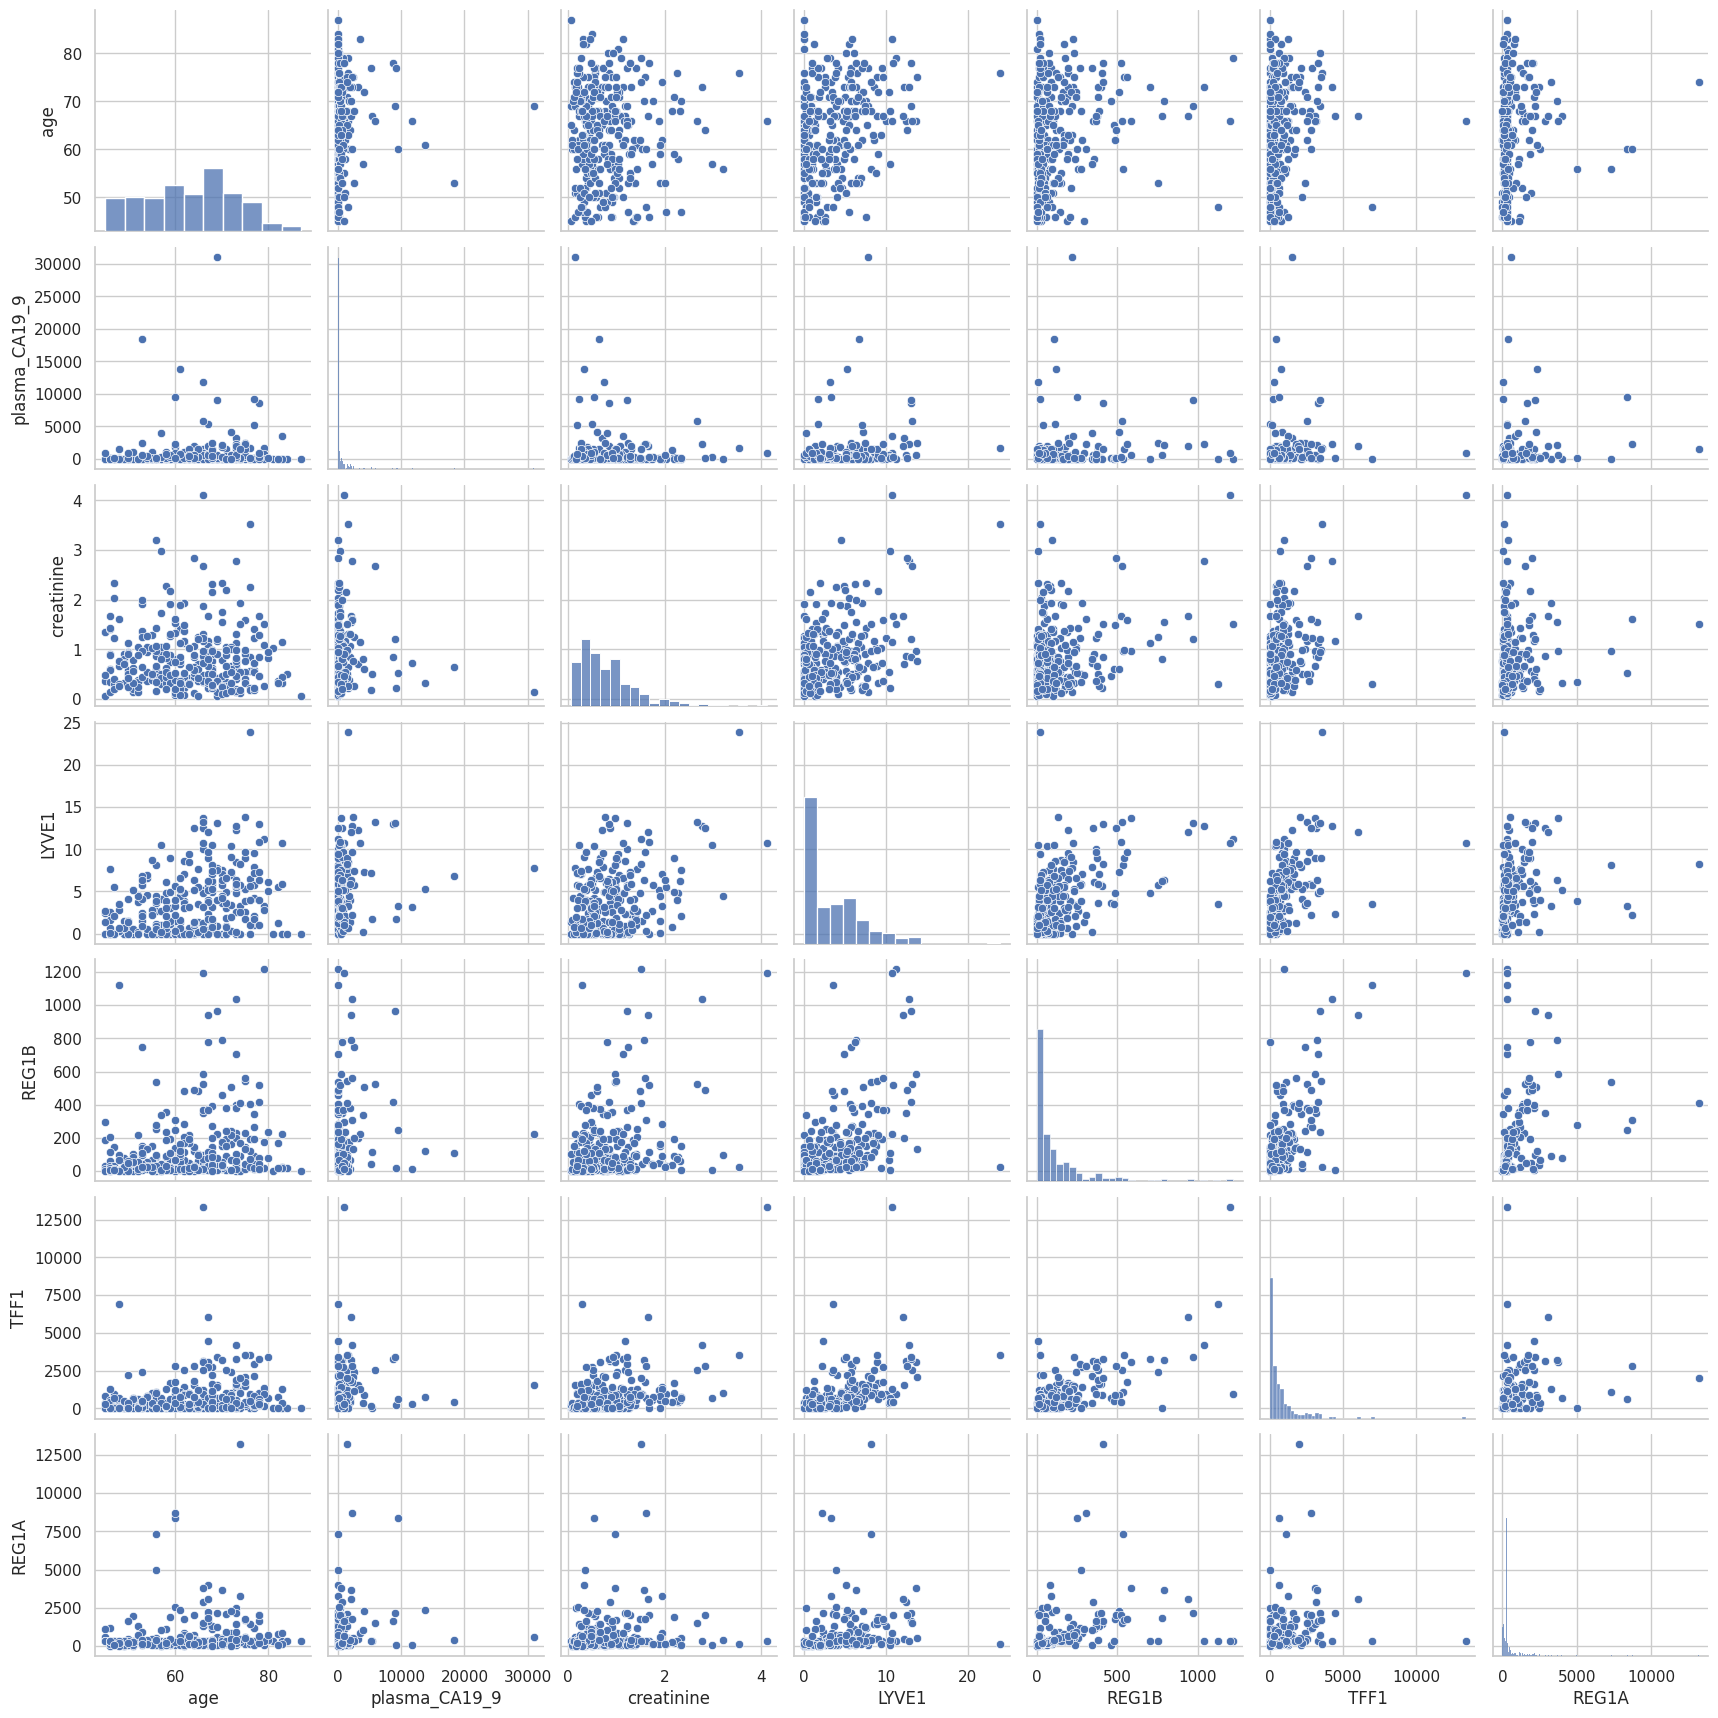

In [23]:
# Set the style for the plots
sns.set(style="whitegrid")

# Pairplot for numerical variables
sns.pairplot(data_blood[['age', 'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']])

Text(0, 0.5, 'Frequency')

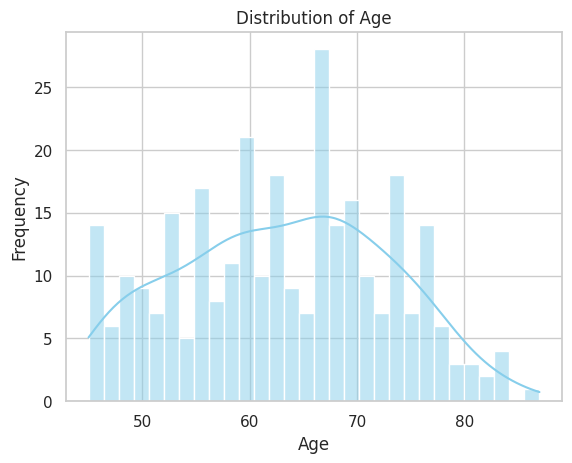

In [24]:
# Distribution of age
sns.histplot(data_blood['age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Correlation Heatmap')

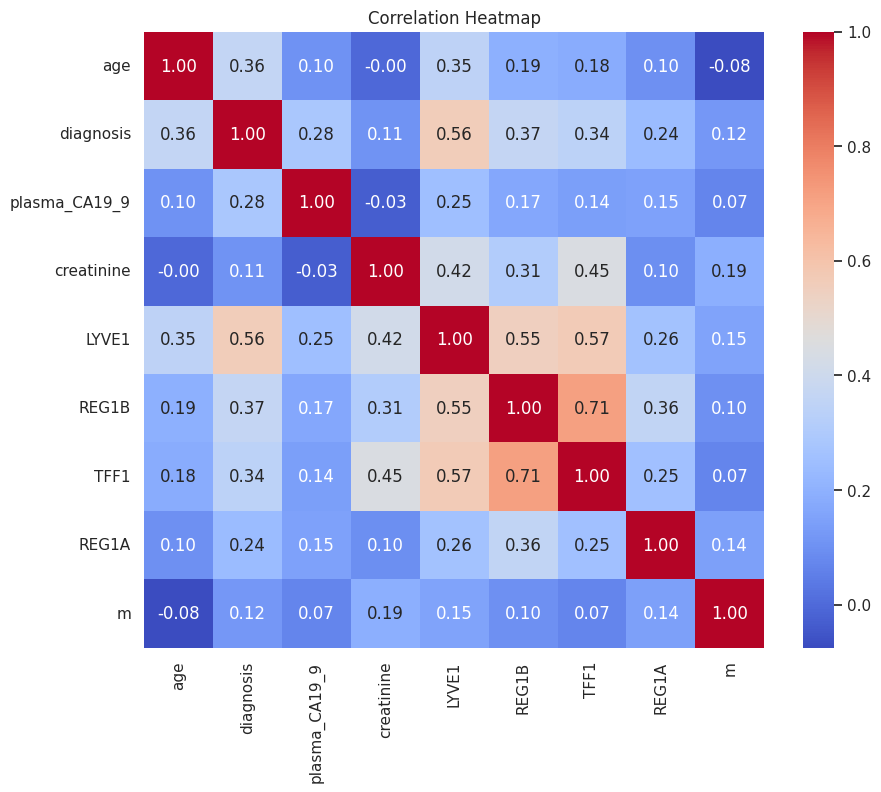

In [25]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_blood.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

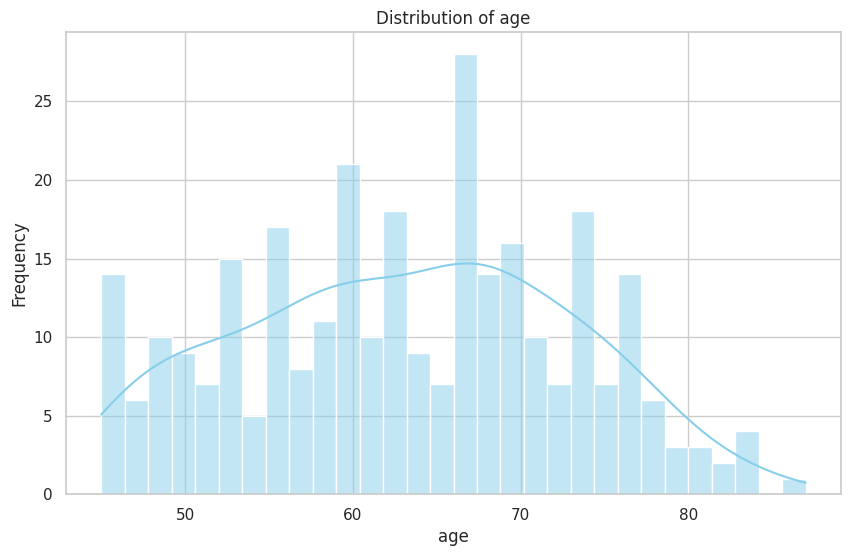

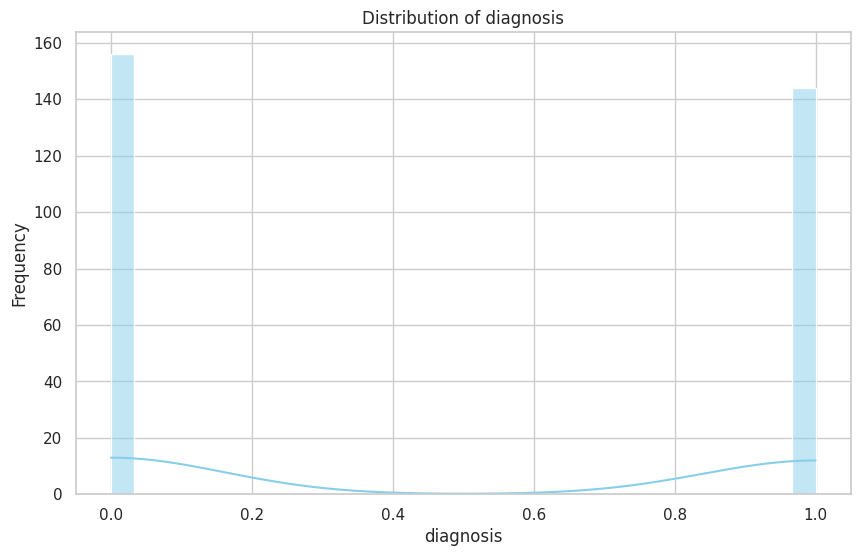

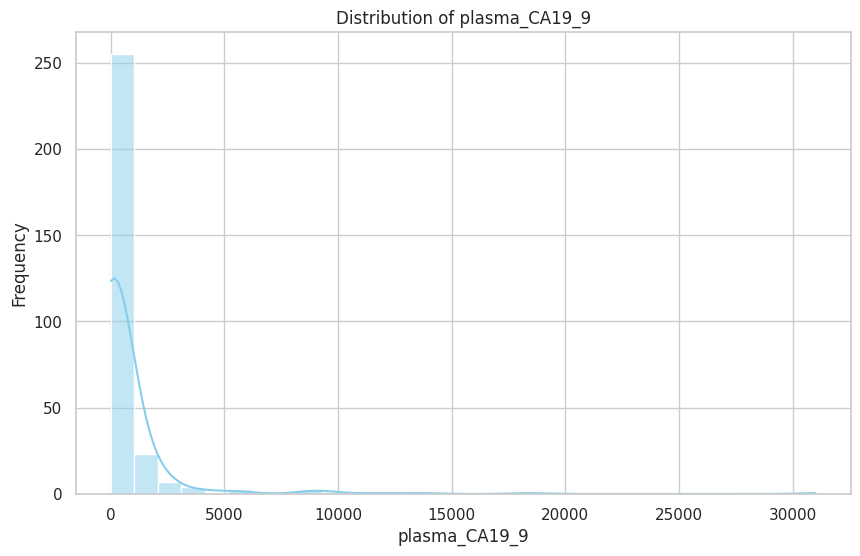

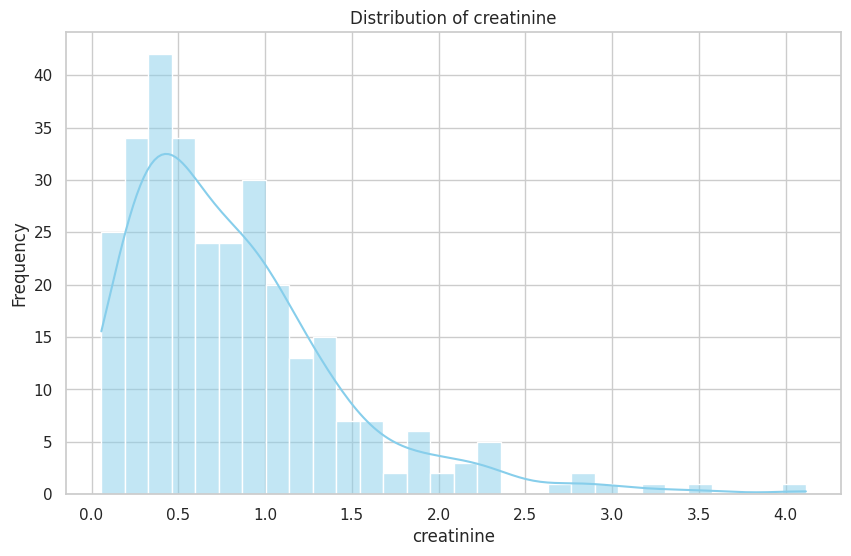

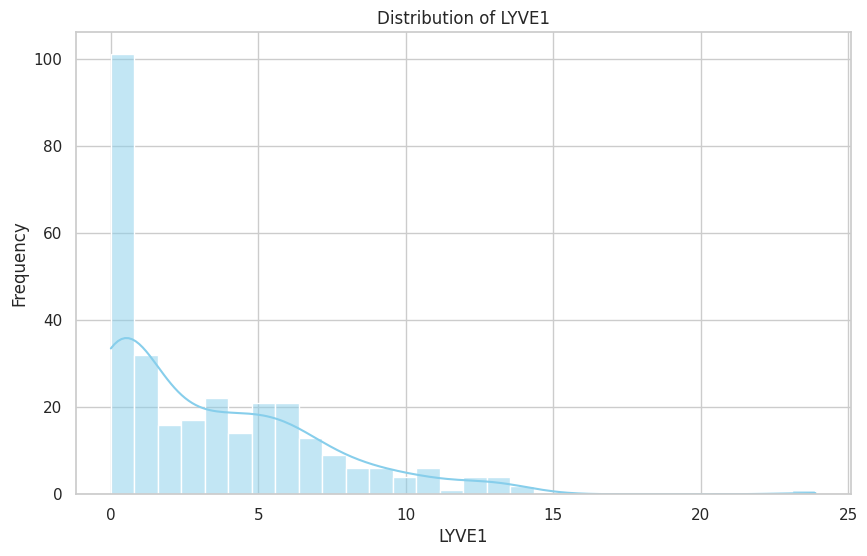

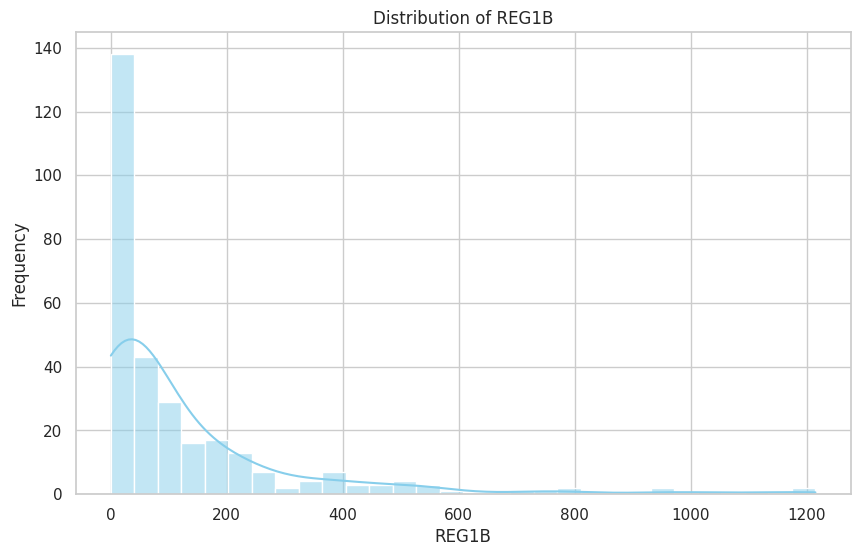

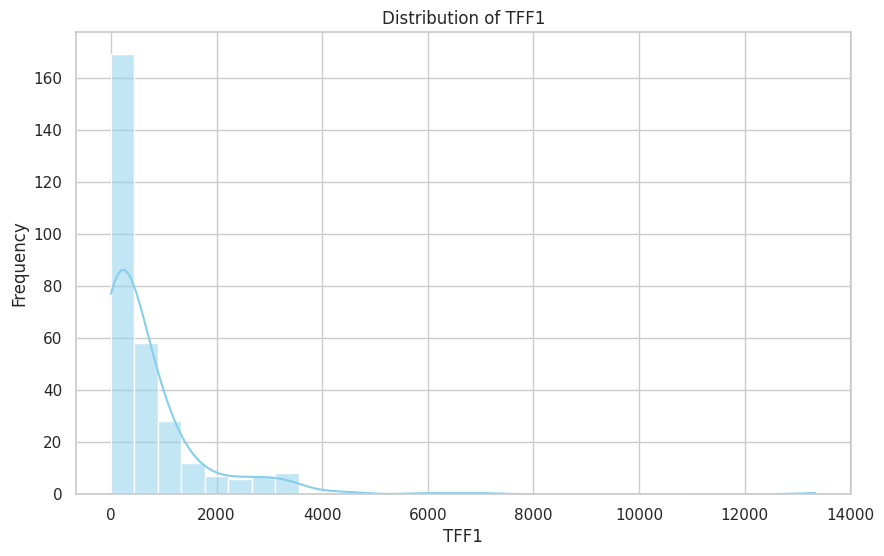

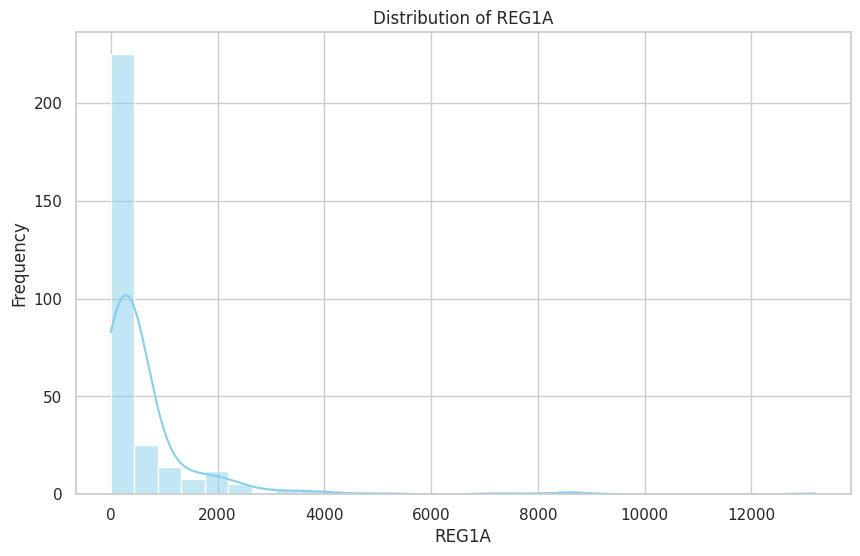

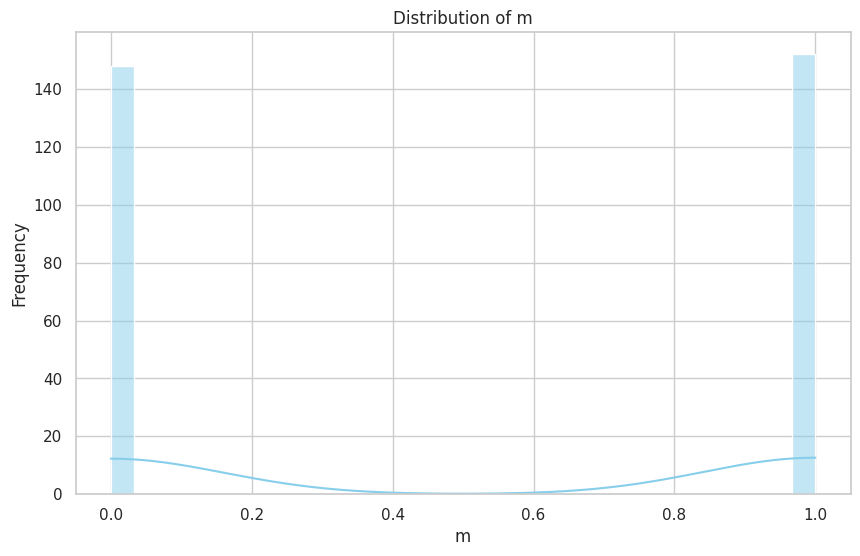

In [26]:
for column in data_blood.columns:
    # Check if the column is numeric (int or float)
    if data_blood[column].dtype in ['int64', 'float64']:
        # Create a histogram
        plt.figure(figsize=(10, 6))
        sns.histplot(data_blood[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

As we can see, all the data is skewed to 0, with features of note being outliers. To deal with this:
We could, use a log transformation, square root transform etc. As I want to try a simple SVM here, I will apply Quantile Transformation.

**ML Model**

We will first train a simple SVM

In [27]:
## We will transform our data using a quantile transform as the data is skewed

# List of numerical features to be transformed
numerical_features = ['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']

# Create a copy of the original DataFrame
data_transformed = data_blood.copy()

# Create a new DataFrame for quantile-transformed features
transformed_columns = []
for feature in numerical_features:
    if feature not in ['age', 'sex', 'diagnosis']:
        transformer = QuantileTransformer(output_distribution='normal', random_state=42)
        transformed_data = transformer.fit_transform(data_blood[[feature]])
        data_transformed[feature + '_quantile'] = transformed_data
        transformed_columns.append(feature + '_quantile')
        
        
# Include 'age', 'sex', 'diagnosis' columns in the new DataFrame
transformed_columns += ['age', 'm', 'diagnosis']

# Create a new DataFrame containing the specified columns
data_transformed_quantiles = data_transformed[transformed_columns]

n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.


In [28]:
#Split our target and features
X_quantiles = data_transformed_quantiles.drop(columns=['diagnosis']) 
y_quantiles = data_transformed_quantiles['diagnosis']


# Split the data into training and testing sets, testing set is 20%
X_train, X_test, y_train, y_test = train_test_split(X_quantiles, y_quantiles, test_size=0.2, random_state=42)


# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=42)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)


Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.80      0.93      0.86        30

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



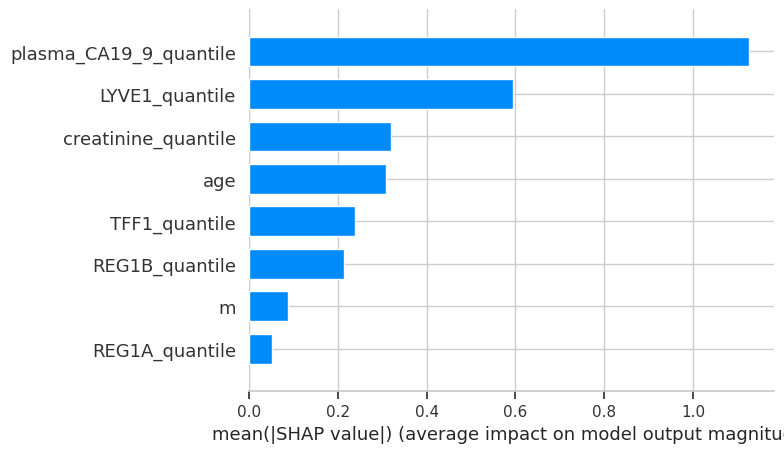

In [29]:
# Evaluate the performance of the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(svm_classifier, X_train)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_quantiles.columns, plot_type='bar', show=False)
plt.show()

In [30]:
# Evaluate the performance of the SVM model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.80      0.93      0.86        30

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60

Sensitivity: 0.9333333333333333
Specificity: 0.7666666666666667


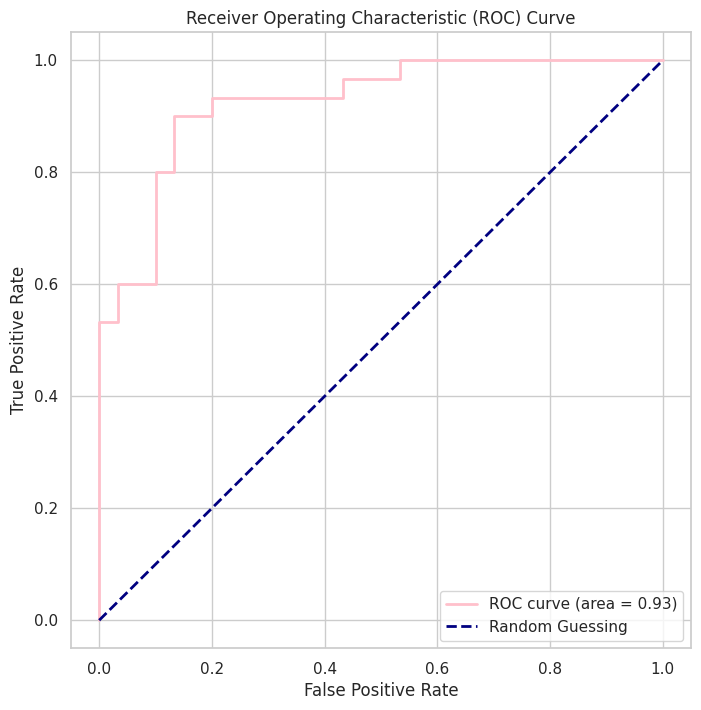

In [31]:
##Creating AUROC curve

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1, probability=True, random_state=42)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = svm_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fp_svm, tp_svm, thresholds = roc_curve(y_test, y_prob,drop_intermediate=False)
roc_auc = auc(fp_svm, tp_svm)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fp_svm, tp_svm, color='pink', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve_svm.png')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



We can also try logisitic regression. Here it makes sense to transform the data via the log transform.

In [32]:
#We'll be doing a log transform for the inputs here
data_transformed = data_blood.copy()

# Apply log transformation to selected numerical features
for feature in numerical_features:
    if feature not in ['age', 'm', 'diagnosis']:
        data_transformed[feature + '_log'] = np.log1p(data_blood[feature])

# Drop the original numerical features
data_transformed = data_transformed.drop(columns=numerical_features)


# Separate features and target variable
X_logreg = data_transformed.drop(columns=['diagnosis'])  # Adjust column names accordingly
y_logreg = data_transformed['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create a logistic regression model
logistic_regression_model = LogisticRegression(random_state=42)

# Train the logistic regression model on the training data
logistic_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test_scaled)




In [33]:
# Evaluate the performance of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)

Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.78      0.93      0.85        30

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60



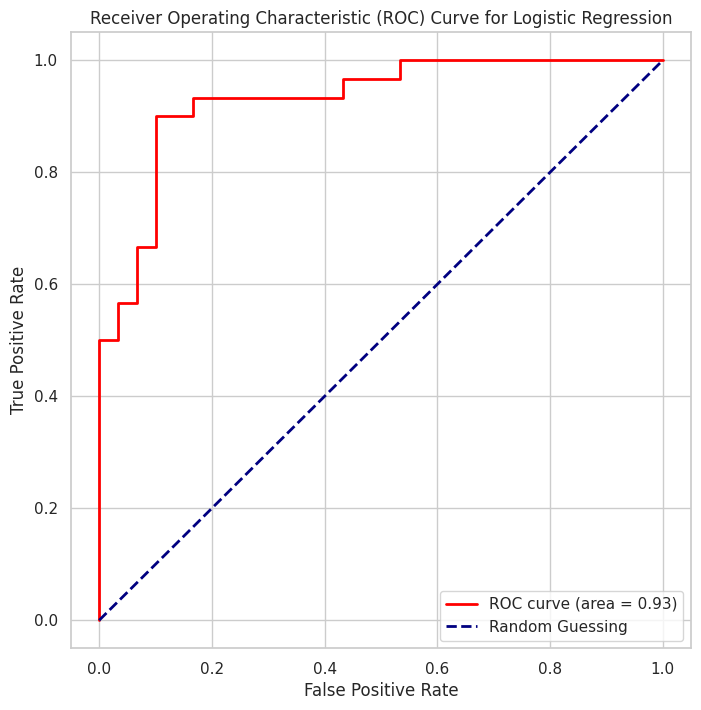

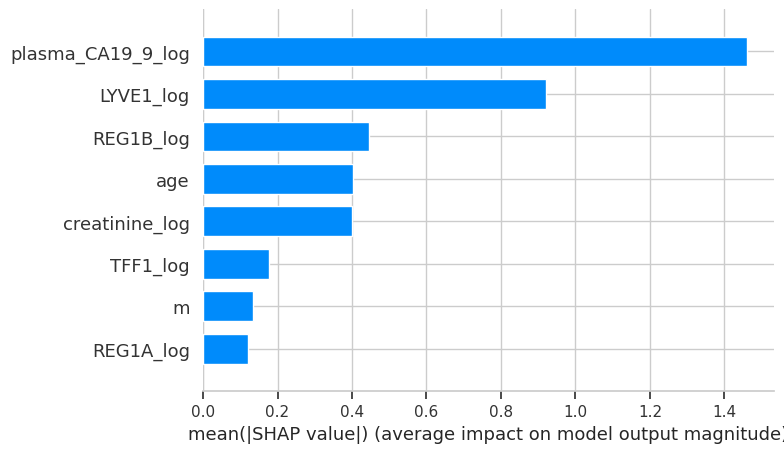

In [34]:
#Make AUROC curve
# Get predicted probabilities for the positive class
y_prob = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve_LogReg.png')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(logistic_regression_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_logreg.columns, plot_type='bar', show=False)
plt.show()

In [35]:
# Evaluate the performance of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print("Confusion Matrix:")
print(conf_matrix)

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[22  8]
 [ 2 28]]
Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.78      0.93      0.85        30

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60

Sensitivity: 0.9333333333333333
Specificity: 0.7333333333333333


**XGBoost Model**

Now tree XGBoost model

In [36]:
## Use the smoothed data from log transform
#We'll be doing a log transform for the inputs here
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create an XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

In [37]:
# Evaluate the performance of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print("Confusion Matrix:")
print(conf_matrix)

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[24  6]
 [ 1 29]]
Accuracy: 0.8833333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.83      0.97      0.89        30

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60

Sensitivity: 0.9666666666666667
Specificity: 0.8


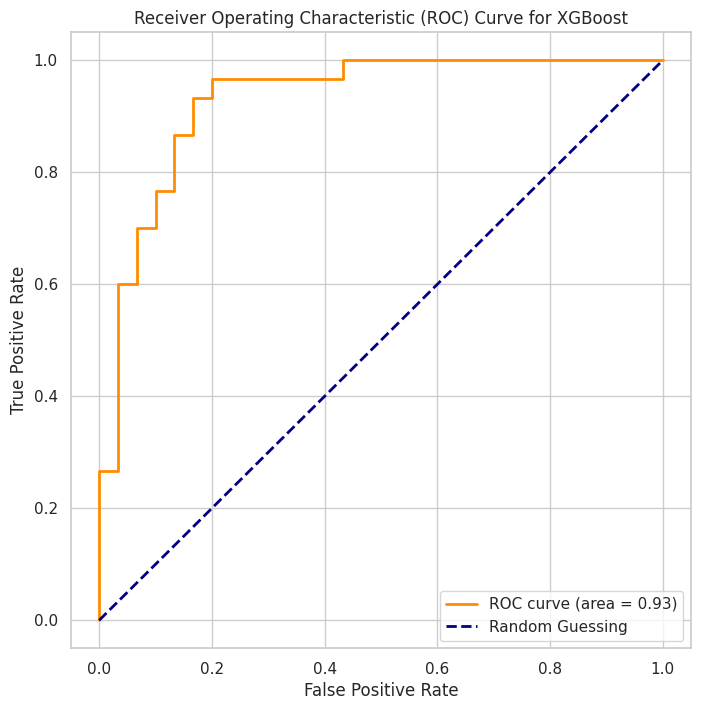

In [38]:
# Get predicted probabilities for the positive class
y_prob_xgb = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve for XGBoost
plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve_xgboost.png')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()


[22:53:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


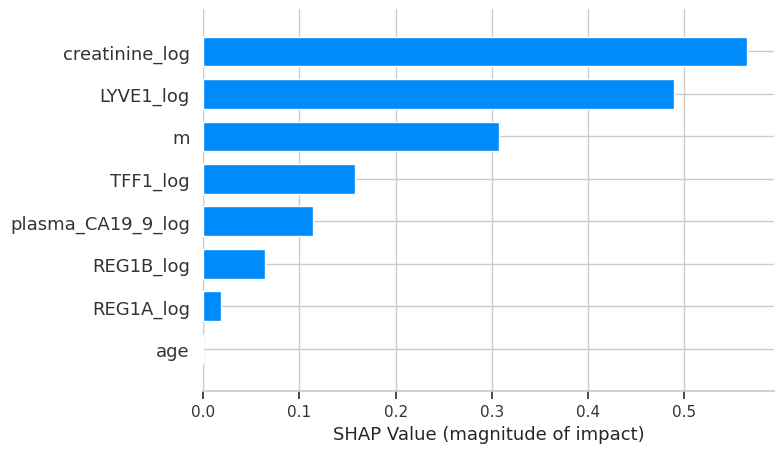

In [39]:
 #Create the explainer
explainer = shap.Explainer(xgb_classifier, X_train)

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# Get feature importance order
feature_importance = np.abs(shap_values).mean(axis=0)
feature_order = np.argsort(feature_importance)[::-1]
sorted_feature_names = X_test.columns[feature_order]

# Plot the SHAP summary plot for all features
plt.figure(figsize=(10, 9))
shap.summary_plot(shap_values[:, feature_order], X_test[sorted_feature_names], feature_names=sorted_feature_names, plot_type='bar', show=False)


plt.xlabel('SHAP Value (magnitude of impact)')
plt.savefig('SHAP_XGB.png')

# Show the plot
plt.show()

**Neural Network Model**
Finally, we'll do the same  with a simple neural network model. This is the most similar archietecture to what we are proposing for the real model.


In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1))

# Define a simple feedforward neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = SimpleModel(X_train_scaled.shape[1])

# Convert to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Compile the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCELoss()  # Use BCELoss instead of BCEWithLogitsLoss for this architecture

# Training loop
epochs = 10
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_labels = (test_outputs > 0.5).float().cpu().numpy()

accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted_labels)
classification_report_output = classification_report(y_test_tensor.cpu().numpy(), predicted_labels)
conf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), predicted_labels)

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print("Confusion Matrix:")
print(conf_matrix)

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Test Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_output)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[16 14]
 [ 2 28]]
Test Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.53      0.67        30
         1.0       0.67      0.93      0.78        30

    accuracy                           0.73        60
   macro avg       0.78      0.73      0.72        60
weighted avg       0.78      0.73      0.72        60

Sensitivity: 0.9333333333333333
Specificity: 0.5333333333333333


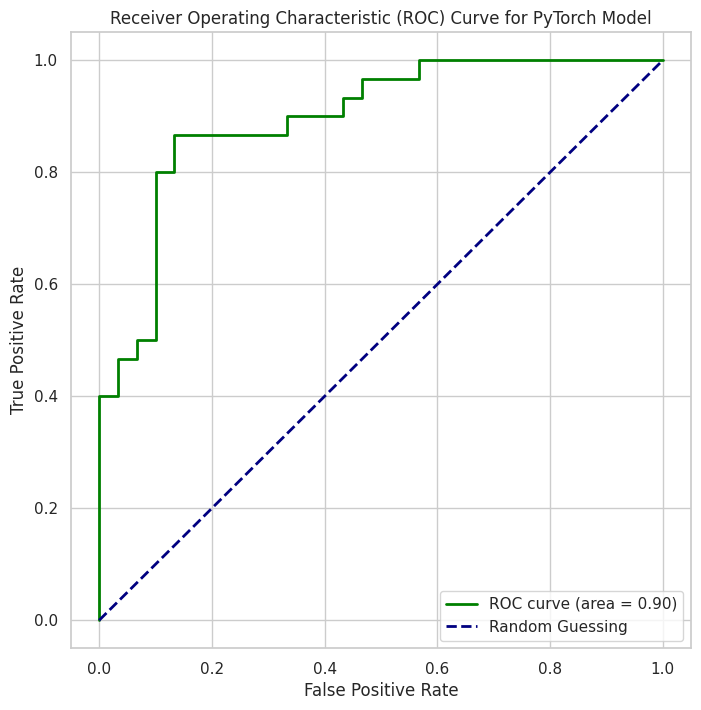

In [41]:
# Get predicted probabilities for the positive class from the PyTorch model
model.eval()
with torch.no_grad():
    y_prob_pytorch = model(X_test_tensor).cpu().numpy()

# Compute ROC curve and AUC for the PyTorch model
fpr_pytorch, tpr_pytorch, thresholds_pytorch = roc_curve(y_test_tensor.cpu().numpy(), y_prob_pytorch)
roc_auc_pytorch = auc(fpr_pytorch, tpr_pytorch)

# Plot ROC curve for the PyTorch model
plt.figure(figsize=(8, 8))
plt.plot(fpr_pytorch, tpr_pytorch, color='green', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_pytorch))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve_NN.png')
plt.title('Receiver Operating Characteristic (ROC) Curve for PyTorch Model')
plt.legend(loc='lower right')
plt.show()

**Plots**
Plot all ROCs together for style


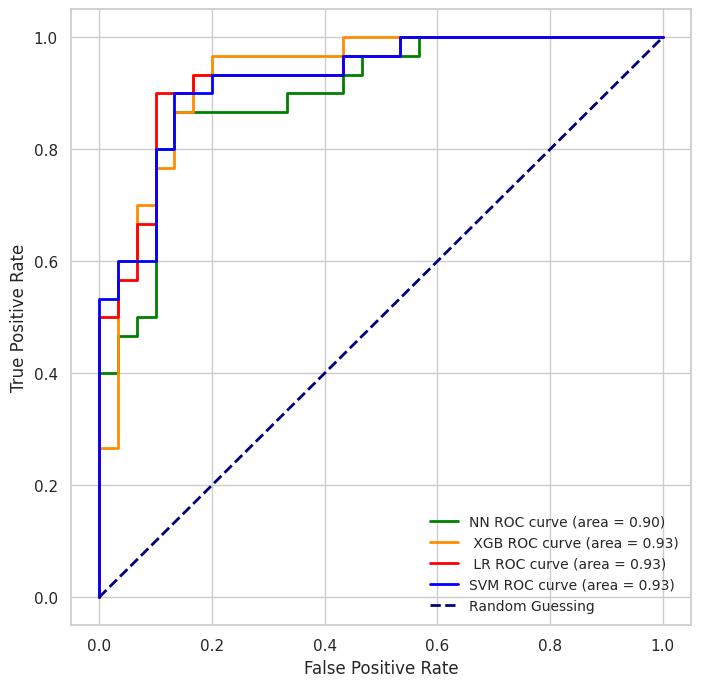

In [42]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_pytorch, tpr_pytorch, color='green', lw=2, label='NN ROC curve (area = {:.2f})'.format(roc_auc_pytorch))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=' XGB ROC curve (area = {:.2f})'.format(roc_auc_xgb))
plt.plot(fpr, tpr, color='red', lw=2, label=' LR ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot(fp_svm, tp_svm, color='blue', lw=2, label='SVM ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.legend(loc='lower right', fontsize='small', frameon=False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve.png')